<a href="https://colab.research.google.com/github/ankamdivija/Flood-Detection-using-Machine-Learning-Techniques/blob/master/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random as rand
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim  
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

Using TensorFlow backend.


In [ ]:
embeddings_index = {}
f = codecs.open('./wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

928315it [02:04, 7459.68it/s]


found 928315 word vectors


In [ ]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def splitIntoStem(message):
    return [removeNumeric(stripEmoji(singleCharacterRemove(removePunctuation
                                                           (removeHyperlinks
                                                            (removeHashtags
                                                             (removeUsernames
                                                              (stemWord(word)))))))) for word in message.split()]
def stemWord(tweet):
    return tweet.lower()

def removeUsernames(tweet):
    return re.sub('@[^\s]+', '', tweet)

def removeHashtags(tweet):
    return re.sub(r'#[^\s]+', '', tweet)

def removeHyperlinks(tweet):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet)

def removeNumeric(value):
    blist2 = [item for item in value if not item.isdigit()]
    blist3 = "".join(blist2)
    return blist3

def removePunctuation(tweet):

    return re.sub(r'[^\w\s]','',tweet)

def singleCharacterRemove(tweet):
    return re.sub(r'(?:^| )\w(?:$| )', ' ', tweet)

def stripEmoji(text):

    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

In [ ]:
tweets_df = pd.read_csv('./tweets_dataset1.csv', sep=',', header=0)
tweet_list = tweets_df['tweet'].tolist()
# label_list = tweets_df['Label'].tolist()
# one_hot_labels = keras.utils.to_categorical(label_list, num_classes=4)
label_names = ["business", "entertainment", "health", "politics"]
labels = tweets_df[label_names].values

In [ ]:
processed_list = []
for sentence in tqdm(tweet_list):
    tokens = " ".join(splitIntoStem(sentence)).split()
    filtered = [word for word in tokens if word not in stop_words]
    processed_list.append(" ".join(filtered))

100%|██████████████████████████████████████████████████████████████████████████| 21149/21149 [00:02<00:00, 9116.98it/s]


In [ ]:
df = pd.DataFrame()
df["tweet"] = processed_list
df['doc_len'] = df['tweet'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len

11

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(processed_list, one_hot_labels, test_size=0.35)
x_train, x_test, y_train, y_test = train_test_split(processed_list, labels, test_size=0.2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train + x_test)
word_seq_train = tokenizer.texts_to_sequences(x_train)
word_seq_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  20091


In [ ]:
num_tokens = [len(tokens) for tokens in word_seq_train + word_seq_test]
num_tokens = np.array(num_tokens)
num_tokens

array([ 9,  6,  5, ...,  3,  5, 11])

In [ ]:
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

In [ ]:
word_seq_test = word_seq_test[:-1]
y_test = y_test[:-1]

In [ ]:
#training params
batch_size = 1024
epochs = 12

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#Binary to Real Mapping
Num_filters = [32, 64, 128, 256]
Batch = [64, 256, 1024, 2048]
Filter_size = [5, 7, 9, 11]
# x -> np array BPSO Particle
x = np.random.randint(2, size = 6)
print(x)
nf = int("".join(map(str, x[0:2])), 2)
bp = int("".join(map(str, x[2:4])), 2)
fs = int("".join(map(str, x[4:6])), 2)
num_filters = Num_filters[nf]
bp = Batch[bp]
filter_size = Filter_size[fs]

[0 0 0 0 1 1]


In [ ]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
embedding_matrix2 = np.zeros((nb_words, embed_dim))

In [ ]:
words_not_found = []

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 4142
sample words not found:  ['newsjoin' 'accidentwere' 'samph' 'abramowitz' 'thenameisaa' 'lowes'
 'secondmost' 'nightâ' 'mcdevitt' 'muâ']


In [ ]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix2[i] = embedding_vector
    except KeyError:
        embedding_matrix2[i]=np.random.normal(0,np.sqrt(0.25),embed_dim)

del(word_vectors)

In [ ]:
model = Sequential()
model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(64, 7, padding='same', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 11, 64)            134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             28736     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________

In [ ]:
model2 = Sequential()
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix2], input_length=max_seq_len, trainable=False))
model2.add(Conv1D(64, 7, padding='same', activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(64, 7, activation='relu', padding='same'))
model2.add(MaxPooling1D(2))
model2.add(GlobalMaxPooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 64)            134464    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 64)             28736     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
__________________________

In [ ]:
history = model.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 14s - loss: 1.3846 - acc: 0.26 - ETA: 8s - loss: 1.3815 - acc: 0.2729 - ETA: 6s - loss: 1.3772 - acc: 0.306 - ETA: 4s - loss: 1.3720 - acc: 0.328 - ETA: 4s - loss: 1.3669 - acc: 0.343 - ETA: 3s - loss: 1.3612 - acc: 0.359 - ETA: 2s - loss: 1.3546 - acc: 0.372 - ETA: 2s - loss: 1.3463 - acc: 0.388 - ETA: 2s - loss: 1.3389 - acc: 0.397 - ETA: 1s - loss: 1.3282 - acc: 0.410 - ETA: 1s - loss: 1.3196 - acc: 0.415 - ETA: 1s - loss: 1.3079 - acc: 0.425 - ETA: 0s - loss: 1.2969 - acc: 0.433 - ETA: 0s - loss: 1.2846 - acc: 0.438 - ETA: 0s - loss: 1.2726 - acc: 0.444 - ETA: 0s - loss: 1.2627 - acc: 0.448 - 4s 261us/step - loss: 1.2569 - acc: 0.4524 - val_loss: 1.0408 - val_acc: 0.5883
Epoch 2/12
16919/16919 [==============================] - ETA: 3s - loss: 1.0361 - acc: 0.597 - ETA: 2s - loss: 1.0230 - acc: 0.593 - ETA: 2s - loss: 1.0125 - acc: 0.593 - ETA: 2s - loss: 1.0050 - acc: 0.

In [ ]:
history2 = model2.fit(word_seq_train, y_train, batch_size = batch_size, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))

Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 16s - loss: 1.3907 - acc: 0.27 - ETA: 9s - loss: 1.3896 - acc: 0.2720 - ETA: 6s - loss: 1.3863 - acc: 0.276 - ETA: 5s - loss: 1.3843 - acc: 0.281 - ETA: 4s - loss: 1.3819 - acc: 0.288 - ETA: 3s - loss: 1.3772 - acc: 0.299 - ETA: 3s - loss: 1.3753 - acc: 0.306 - ETA: 2s - loss: 1.3719 - acc: 0.314 - ETA: 2s - loss: 1.3685 - acc: 0.322 - ETA: 1s - loss: 1.3632 - acc: 0.333 - ETA: 1s - loss: 1.3580 - acc: 0.343 - ETA: 1s - loss: 1.3535 - acc: 0.350 - ETA: 0s - loss: 1.3481 - acc: 0.358 - ETA: 0s - loss: 1.3420 - acc: 0.366 - ETA: 0s - loss: 1.3367 - acc: 0.372 - ETA: 0s - loss: 1.3300 - acc: 0.379 - 5s 284us/step - loss: 1.3264 - acc: 0.3841 - val_loss: 1.1665 - val_acc: 0.5734
Epoch 2/12
16919/16919 [==============================] - ETA: 3s - loss: 1.1837 - acc: 0.532 - ETA: 2s - loss: 1.1834 - acc: 0.527 - ETA: 2s - loss: 1.1710 - acc: 0.525 - ETA: 2s - loss: 1.1615 - acc: 0.

In [ ]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1051
           1       0.67      0.75      0.71      1099
           2       0.74      0.75      0.75      1078
           3       0.83      0.68      0.75      1001

   micro avg       0.72      0.72      0.72      4229
   macro avg       0.73      0.72      0.72      4229
weighted avg       0.73      0.72      0.72      4229



In [ ]:
y_pred = model2.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68      1051
           1       0.64      0.74      0.69      1099
           2       0.72      0.77      0.75      1078
           3       0.79      0.69      0.74      1001

   micro avg       0.71      0.71      0.71      4229
   macro avg       0.72      0.71      0.71      4229
weighted avg       0.72      0.71      0.71      4229



In [ ]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']

epochs = range(1, len(loss1) + 1)

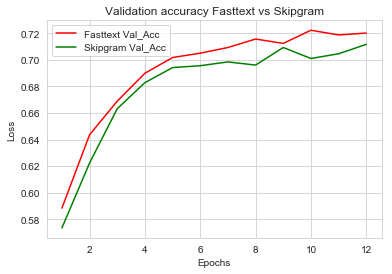

In [ ]:
plt.plot(epochs, val_acc1, color='red', label='Fasttext Val_Acc')
plt.plot(epochs, val_acc2, color='green', label='Skipgram Val_Acc')
plt.title('Validation accuracy Fasttext vs Skipgram')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def cnn_optimizer(x):
    nf = int("".join(map(str, x[0:2])), 2)
    bp = int("".join(map(str, x[2:4])), 2)
    fs = int("".join(map(str, x[4:6])), 2)
    num_filters = Num_filters[nf]
    batch = Batch[bp]
    filter_size = Filter_size[fs]
    return model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_test)

In [ ]:
def model(num_filters, batch, filter_size, word_seq_train, y_train, word_seq_test, y_val):
    model = Sequential()
    model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
    model.add(Conv1D(num_filters, filter_size, padding='same', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    history = model.fit(word_seq_train, y_train, batch_size = batch, epochs = epochs, shuffle = True, validation_data = (word_seq_test, y_test))
    score, acc = model.evaluate(word_seq_test, y_test)
    print('Val accuracy:', acc)
    return acc

In [ ]:
D = 6
N = 6
w = 0.7
c1 = np.random.rand()
c2 = np.random.rand()
iter_num = 5

In [ ]:
class Particle:
    def __init__(self, D):
        self.velocity = np.zeros(D)
        self.coordinates = np.random.randint(2, size = D)
        self.best_position = np.copy(self.coordinates)
        self.best_score = 0

    def __update_velocity(self, group_best_pos, w, c1, c2):
        self.velocity = w * self.velocity + c1 * rand.random() * (self.best_position - self.coordinates) + c2 * rand.random() * (group_best_pos - self.coordinates)
    
    def compare_update(self, s):
        if s < np.random.rand(1):
            return 1
        else:
            return 0
    
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def move(self, group_best_pos, w, c1, c2, fitness_function):
        self.__update_velocity(group_best_pos, w, c1, c2)
        self.coordinates = list(map(self.compare_update, list(map(self.sigmoid, self.velocity))))
        current_score = fitness_function(self.coordinates)        
        if current_score > self.best_score:
            self.best_position = np.copy(self.coordinates)
            self.best_score = current_score

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-(x)))
    
    def __str__(self):
        return (
        'Current velocity = {0};\nPosition: {1};\nBest position so far: {2};\nScore for the best position = {3}.\n' \
        .format(self.velocity, self.coordinates, self.best_position, self.best_score))

In [ ]:
class Swarm:
    def __init__(self, D, N, w, c1, c2, iter_num):
        self.particles = [Particle(D) for _ in range(N)]
        self.dimension = D
        self.particles_num = N
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.iter_num = iter_num

        rnd_particle = self.particles[np.random.randint(N)]
        self.group_best_position = np.copy(rnd_particle.coordinates)
        self.group_best_score = self.fitness_function(rnd_particle.coordinates)
        for p in self.particles:
            print(p.__str__())

    def _update_group_best(self):
        for p in self.particles:
            if p.best_score > self.group_best_score:
                self.group_best_score = p.best_score
                self.group_best_position = np.copy(p.coordinates)

    def _move_all(self):
        for p in self.particles:
            p.move(self.group_best_position, self.w, self.c1, self.c2, self.fitness_function)

    def optimize(self):
        i = 0
        self._update_group_best()
        while(i < self.iter_num):
            self._move_all()
            self._update_group_best()
            i += 1
            print(i," iteration grp_best: ",self.group_best_position)
            for p in self.particles:
                print(p.__str__())
        return self.group_best_position
    
    def fitness_function(self, x):
        return cnn_optimizer(x)
    
    def __str__(self):
        return 'Best one:{0}'.format(self.group_best_position)

In [ ]:
s = Swarm(D, N = N, w = w, c1 = c1, c2 = c2, iter_num = iter_num)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 11, 32)            86432     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 6,114,920
Trainable params: 87,620
Non-trainable params: 6,027,300
_________________________________________________________________
Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 59s - loss: 1.4

In [ ]:
parameters = s.optimize()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 11, 300)           6027300   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 11, 128)           268928    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 6,300,488
Trainable params: 273,188
Non-trainable params: 6,027,300
_________________________________________________________________
Train on 16919 samples, validate on 4229 samples
Epoch 1/12
16919/16919 [==============================] - ETA: 4:06 - loss: 1

In [ ]:
cnn_optimizer(parameters)

In [ ]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
epochs = range(1, len(loss1) + 1)

In [ ]:
plt.plot(epochs, loss1, color='red', label='Training loss')
plt.plot(epochs, val_loss1, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, acc1, color='red', label='Training acc')
plt.plot(epochs, val_acc1, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(word_seq_test)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis = 1)
print(classification_report(rounded_labels, y_pred_bool))

In [ ]:
print(confusion_matrix(rounded_labels, y_pred_bool))

In [ ]:
print(accuracy_score(rounded_labels, y_pred_bool))